In [1]:
import requests as r
import pandas as pd
import json
import numpy as np
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

2021-08-17 23:28:43.190958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-17 23:28:43.191038: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Obtengo datasets

Utilizando la API de [mobidb](https://mobidb.bio.unipd.it/) descargo en formato JSON los proteomas de _Homo sapiens_ , _Danio rerio_ , y _Gallus gallus_. Hago un backup de los datos en la carpeta `src/pickle/raw_mobidb_data` para no redescargar los datos.

Luego examiné la longitud de secuencias para tratar de establecer cual sería la secuencia mas corta que resultase significativa, teniendo en cuenta que voy a tener que _paddear_ los datos para que todos los datos sean igualemente largos. Los datos con secuencias 'recortadas' quedan guardados en la variable `curated_data`.

In [2]:
url='https://mobidb.bio.unipd.it/api/download?proteome=UP000005640&format=json'
human_proteome_data=r.get(url).json()

In [3]:
url_drosophila='https://mobidb.bio.unipd.it/api/download?proteome=UP000000803&format=json'
drosophila_proteome_data=r.get(url_drosophila).json()

In [157]:
url_celegans='https://mobidb.bio.unipd.it/api/download?proteome=UP000001940&format=json'
celegans_proteome_data=r.get(url_celegans).json()

In [4]:
url_danio='https://mobidb.bio.unipd.it/api/download?proteome=UP000000437&format=json'
danio_proteome_data=r.get(url_danio).json()

url_gallus='https://mobidb.bio.unipd.it/api/download?proteome=UP000000539&format=json'
gallus_proteome_data=r.get(url_gallus).json()

In [158]:
proteome_data=human_proteome_data+drosophila_proteome_data+gallus_proteome_data+danio_proteome_data+celegans_proteome_data

In [159]:
with open('pickle/raw_mobidb_data/proteomes.json', 'w') as file:
    json.dump(proteome_data, file)

In [160]:
sequences=[protein['sequence'] for protein in proteome_data]

In [161]:
seqlengths=[len(sequence) for sequence in sequences]

In [162]:
sl=sorted(seqlengths)

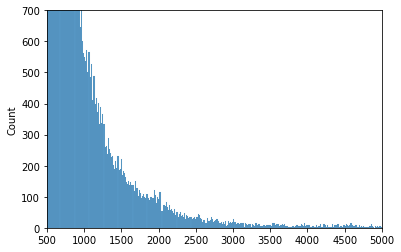

In [163]:
sns.histplot(sl)
plt.ylim(top=700)
plt.xlim((500,5000))
plt.savefig('../misc/plots/plot_protsize.png')

In [164]:
curated_data=[]
for n,node in enumerate(proteome_data):
    if len(node['sequence']) < 1500:
        curated_data.append(node)


## Categorias 'Omniprescentes'


La idea es determinar cual de todas las categorías están presentes en todos los datos, para poder luego decidir cuál campo uso como UID

In [165]:
all_keys=[]
for node in curated_data:
    all_keys+=list(node.keys())
count={}
for key in all_keys:
    count[key]=0
for node in curated_data:
    for k in list(node.keys()):
        count[k]+=1
count_of_omniprescence=len(curated_data)
omnipresent_fields=[]
for key, value in count.items():
    if value == count_of_omniprescence:
        omnipresent_fields.append(key)
omnipresent_fields

['uniref100',
 'taxonomy',
 'sequence',
 'organism',
 'proteome',
 'length',
 'acc',
 'uniparc',
 'ncbi_taxon_id']

## Determino los identificadores de localización


A partir de los datos almacenados en `curated_data` determino cuales datos tienen información sobre la localización subcelular de la proteina. En esta base de datos, cada proteina cuenta con una lista describiendo esta información. Tomo entonces los nodos de esta lista, para tratar de determinar cuales son todas las localizaciones posibles, almacenados en la variable `all_descriptors`.

Algunas de estas localizaciones describen conjuntos de localización especifica y general con el formato "ubicación-general:ubicación-general", por ejemplo: '\[80 kda soluble fragment\]: secreted' o '\[beta-dystroglycan\]: cell membrane'. En estos casos me interesa particularmente la ubicación general. Almaceno esta información en las variables `colon_descriptors` y `colon_descriptor_categories`.

Luego voy a tomar la información almacenada en `colon_descriptor_categories` para filtrar las proteinas por localización.

In [166]:
localized=[]
unlocalized=0
locations=[]
for protein in curated_data:
    try:
        localized.append(protein['localization'])
    except KeyError as e:
        if e.args[0]=='localization':
            unlocalized+=1

for location in localized:
    locations+=location
locations=set(locations)
all_descriptors=[]
for location in locations:
    mezza=[loc.strip().lower() for loc in re.split(r";|,", location)]
    all_descriptors+=mezza
all_descriptors=set(all_descriptors)

colon_descriptor_categories=set()
colon_descriptors=set()
for node in all_descriptors:
    if ':' in node:
        colon_descriptors.add(node.lower())
        parts=node.split(':')
        assert len(parts) <= 2
        colon_descriptor_categories.add(parts[1].strip().lower())
    

In [167]:
colon_descriptor_categories

{'cell membrane',
 'cell surface',
 'cytoplasm',
 'cytoplasmic vesicle',
 'cytoplasmic vesicle membrane',
 'endomembrane system',
 'endoplasmic reticulum',
 'endoplasmic reticulum membrane',
 'golgi apparatus',
 'golgi apparatus membrane',
 'lysosome',
 'lysosome lumen',
 'membrane',
 'membrane raft',
 'mitochondrion',
 'mitochondrion inner membrane',
 'mitochondrion matrix',
 'mitochondrion membrane',
 'nucleus',
 'secreted',
 'virion'}

In [168]:
surface=[]
mitochondrion=[]
other=[]
cytoplasm=[]
for node in sorted(list(colon_descriptor_categories)):
    if 'mitoch' in node:
        mitochondrion.append(node)
    elif 'cell' in node or 'membrane' in node  and 'endo' not in node and 'golgi' not in node and 'cyto' not in node:
        surface.append(node)
    elif 'golgi' in node or 'lyso' in node or 'endop' in node:
            other.append(node)
  

In [169]:
cytoplasm,other, surface, mitochondrion

([],
 ['endoplasmic reticulum',
  'endoplasmic reticulum membrane',
  'golgi apparatus',
  'golgi apparatus membrane',
  'lysosome',
  'lysosome lumen'],
 ['cell membrane', 'cell surface', 'membrane', 'membrane raft'],
 ['mitochondrion',
  'mitochondrion inner membrane',
  'mitochondrion matrix',
  'mitochondrion membrane'])

## Formateo los datos 

Voy a intentar reorganizar los datos para poder facilitar el procesamiento subsecuente. Para ello en un primer lugar genero un diccionario que llamaré `urefed_located_data` que contenga el `uref100` de las proteinas como clave y los datos como valores. 

Luego voy a eliminar los datos que _a priori_ no considero necesarios generando el diccionario `categorised_data` que contiene el `uref100` de las proteinas como UID nuevamente, y como valores solo voy a conservar localización y secuencia. También voy a agregar un campo `cats` que luego almacenará las categorías en las que se asignará la proteina, con la idea de no tener proteinas almacenadas en dos categorías distintas.

In [170]:
urefed_curated_data={}
cnte=0
cnt=0
for node in curated_data:
    try:
        _=node['localization']
        urefed_curated_data[node['uniref100']]=node
        cnt+=1
    except KeyError:
        cnte+=1
        pass

print(cnte,cnt)

137037 52912


In [171]:
breaks=0
categorised_data=[]
for key, values in  urefed_curated_data.items():
    for value in values['localization']:
        for val in re.split(r",|:|;", value): 
            if val.lower() in colon_descriptors or val.lower() in colon_descriptor_categories: 
                categorised_data.append({
                'uniref100':values['uniref100'],
                'localization':values['localization'],
                'sequence':values['sequence'],
                'cats':{'number':0,
                       'names':[]}
                })
            breaks+=1
            break
        break
       

In [172]:
labeled_data={
    'other':{},
    'mitochondrion':{},
    'surface':{}
}
deletable=[]
for datum in categorised_data:
    for value in datum['localization']:
        if value.lower() in other: #['nada']:
            labeled_data['other'][datum['uniref100']]=datum
            if 'other' not in datum['cats']['names']:
                datum['cats']['number']+=1
                datum['cats']['names'].append('other')
        if value.lower() in mitochondrion:
            labeled_data['mitochondrion'][datum['uniref100']]=datum
            if 'mitochondrion' not in datum['cats']['names']:
                datum['cats']['number']+=1
                datum['cats']['names'].append('mitochondrion')
        if value.lower() in surface:
            labeled_data['surface'][datum['uniref100']]=datum
#             datum['cats']['number']+=1
            if 'surface' not in datum['cats']['names']:
                datum['cats']['number']+=1
                datum['cats']['names'].append('surface')
        if datum['cats']['number'] > 1:
            deletable.append(datum)

In [173]:
local_combinations=set()
counts={}
for node in deletable:
    local_combinations.add(tuple(node['cats']['names']))
for node in local_combinations:
    counts[node]=0
for node in deletable:
    counts[tuple(node['cats']['names'])]+=1
counts

{('surface', 'other'): 133,
 ('other', 'surface', 'mitochondrion'): 2,
 ('other', 'mitochondrion'): 64,
 ('mitochondrion', 'surface'): 7,
 ('surface', 'other', 'mitochondrion'): 4,
 ('surface', 'mitochondrion'): 55,
 ('other', 'surface'): 84,
 ('mitochondrion', 'other'): 18,
 ('surface', 'mitochondrion', 'other'): 4,
 ('mitochondrion', 'other', 'surface'): 10}

In [174]:
clean_labeled_data=labeled_data.copy()
for repseq in deletable:
    cats=repseq['cats']['names']
    name=repseq['uniref100']
    for cat in cats:
        try:
            del clean_labeled_data[cat][name]
        except KeyError:
            pass
            #print(cat,name)

In [175]:
with open('pickle/json_files/fully_preprocessed.json', 'w') as file:
    json.dump(clean_labeled_data, file)

In [176]:
for k,v in clean_labeled_data.items():
    print('clase {} tiene {} datos'.format(k, len(v)))

clase other tiene 1102 datos
clase mitochondrion tiene 1654 datos
clase surface tiene 1090 datos


In [177]:
mitochondrion_proteins=np.array([ protein['sequence'] for uref, protein in clean_labeled_data['mitochondrion'].items() ])
surface_proteins=np.array([ protein['sequence'] for uref, protein in clean_labeled_data['surface'].items() ])
other_proteins=np.array([ protein['sequence'] for uref, protein in clean_labeled_data['other'].items() ])
all_prot_array=np.hstack([surface_proteins,mitochondrion_proteins,other_proteins])

### Acomodo clases

Como la cantidad de proteinas está desbalanceada en ambas clases, voy a recortar la clase "mitochondrion" para que tenga la misma longitud que "surface"

In [178]:
catlength=np.min([len(mitochondrion_proteins), len(surface_proteins), len(other_proteins) ])
mitochondrion_proteins=np.random.choice(mitochondrion_proteins,catlength, replace=False)
surface_proteins=np.random.choice(surface_proteins,catlength, replace=False)
other_proteins=np.random.choice(other_proteins,catlength, replace=False)

## Codificación numérica

Obtengo todas las posibles variantes de aa en el dataset, le asigno un valor numérico y transformo los arrays en valores numéricos. El código queda guardado en la variable `numeric_code` y en el archivo `numeric_code.json`. Los arrays se llaman `{organela}_proteins_numeric`.

In [179]:
allseqs=''
for sequence in all_prot_array:
    allseqs+=sequence
aas=set()
for val in allseqs:
    aas.add(val)
numeric_code={aa:num for num,aa in enumerate(aas,3)}
with open('pickle/json_files/numeric_code.json', 'w') as file:
    json.dump(numeric_code, file)

In [180]:
surface_proteins_numeric=[]
for sequence in surface_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    surface_proteins_numeric.append(sequence_array)
surface_proteins_numeric=np.array(surface_proteins_numeric)
mitochondrion_proteins_numeric=[]
for sequence in mitochondrion_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    mitochondrion_proteins_numeric.append(sequence_array)
mitochondrion_proteins_numeric=np.array(mitochondrion_proteins_numeric)
other_proteins_numeric=[]
for sequence in other_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    other_proteins_numeric.append(sequence_array)
other_proteins_numeric=np.array(mitochondrion_proteins_numeric)



/tmp/ipykernel_19416/3002189762.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  surface_proteins_numeric=np.array(surface_proteins_numeric)
/tmp/ipykernel_19416/3002189762.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mitochondrion_proteins_numeric=np.array(mitochondrion_proteins_numeric)


## Manejo de arrays final

Para tener un dataset uniforme, paddeo las secuencias para que todos los arrays tengan la misma longitud, y hago un vstack para que en lugar de tener un array de arrays (deprecadisimo) tenga un 2D-array. Luego genero los labels acorde a la organela a la que pertenezca la secuencia y guardo los files en la carpeta `src/pickle/numpy_arrays` con formato `.npy` para cada dataset individualmente y todo junto como un paquete `.npz`

In [181]:
padded_surface_proteins=np.vstack(pad_sequences(surface_proteins_numeric,padding='post', maxlen=1500))
padded_mitochondrion_proteins=np.vstack(pad_sequences(mitochondrion_proteins_numeric,padding='post',maxlen=1500))
padded_other_proteins=np.vstack(pad_sequences(other_proteins_numeric,padding='post',maxlen=1500))

In [182]:
padded_other_proteins.shape,padded_surface_proteins.shape, padded_mitochondrion_proteins.shape

((1090, 1500), (1090, 1500), (1090, 1500))

In [183]:
data=np.vstack([padded_surface_proteins, padded_mitochondrion_proteins, padded_other_proteins])

In [184]:
data.shape

(3270, 1500)

In [185]:
np.save('pickle/numpy_arrays/padded_surface_proteins', padded_surface_proteins)
np.save('pickle/numpy_arrays/padded_mitochondrion_proteins',padded_mitochondrion_proteins)
np.save('pickle/numpy_arrays/padded_other_proteins',padded_other_proteins)
np.save('pickle/numpy_arrays/labels', labels)


In [186]:
# labels=np.hstack([np.zeros(padded_surface_proteins.shape[0]),np.ones(padded_mitochondrion_proteins.shape[0])]).reshape(-1,1)
labels=np.hstack((np.full(catlength, 0),np.full(catlength, 1),np.full(catlength, 2))).reshape(-1,1)

In [188]:
labels

array([[0],
       [0],
       [0],
       ...,
       [2],
       [2],
       [2]])

In [187]:
np.savez('pickle/numpy_arrays/preprocessed_data', data=data, labels=labels)